参考:[https://data-analysis-stats.jp/深属学習/u-netによる画像セグメンテーションimage-segmentationの解説/](https://data-analysis-stats.jp/深属学習/u-netによる画像セグメンテーションimage-segmentationの解説/)

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.8MB 19.0MB/s 


In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
 
import numpy as np
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,concatenate,Conv2DTranspose,Lambda,Multiply,Add,Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
import tensorflow_datasets as tfds
from tensorflow.keras.backend import int_shape,mean
 
tfds.disable_progress_bar()
 
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_ex

# データ読み込み

In [5]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

# データの前処理

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BUFFER_SIZE = 1000
BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# マスクの表示

In [7]:
def display(display_list):
   plt.figure(figsize=(15, 15))

   title = ['Input Image', 'True Mask', 'Predicted Mask']

   for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      plt.axis('off')
      plt.show()

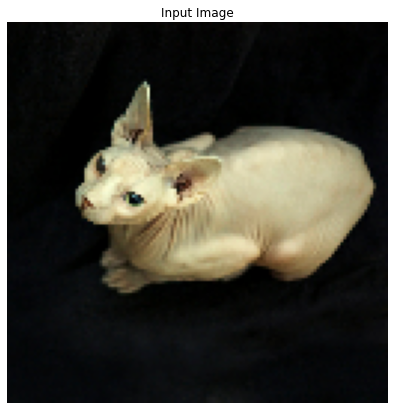

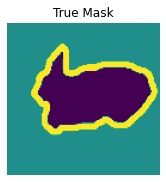

In [8]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

 # データ加工

In [9]:
# generator化
result = tfds.as_numpy(train)
result_test = tfds.as_numpy(test)

# 空のnumpyを用意してからadd
x_train = np.empty((TRAIN_LENGTH,128,128,3))
y_train = np.empty((TRAIN_LENGTH,128,128,1))

for i,ele in enumerate(result):
  x_train[i] = ele[0]
  y_train[i] = ele[1]
  # 空のnumpyを用意してからadd
  x_test = np.empty((info.splits['test'].num_examples,128,128,3))
  y_test = np.empty((info.splits['test'].num_examples,128,128,1))

for i,ele in enumerate(result_test):
  x_test[i] = ele[0]
  y_test[i] = ele[1]

# データの確認

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3680, 128, 128, 3)
(3680, 128, 128, 1)
(3669, 128, 128, 3)
(3669, 128, 128, 1)


In [11]:
OUTPUT_CHANNELS = 3
IMG_HEIGHT =128
IMG_WIDTH =128

inputs = Input((IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
p4 = MaxPooling2D((2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
p5 = MaxPooling2D((2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
c6 = BatchNormalization() (c6)
p6 = MaxPooling2D((2, 2)) (c6)

mid = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p6)

u7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (mid)
c7 = concatenate([u7, c6])
c7 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c7)
c8 = concatenate([u8, c5])
c8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c8)
c9 = concatenate([u9, c4], axis=3)
u9 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (u9)
c10 = concatenate([u10, c3], axis=3)
u10 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)

u11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (u10)
c11 = concatenate([u11, c2], axis=3)
u11 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c11)

u12 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (u11)
c12 = concatenate([u12, c1], axis=3)
u12 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c12)

outputs = Conv2D(1, (1, 1)) (u12)
model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam',
    #loss=tf.keras.losses.CategoricalCrossentropy(),
    loss='mse',
    metrics=['mse'])

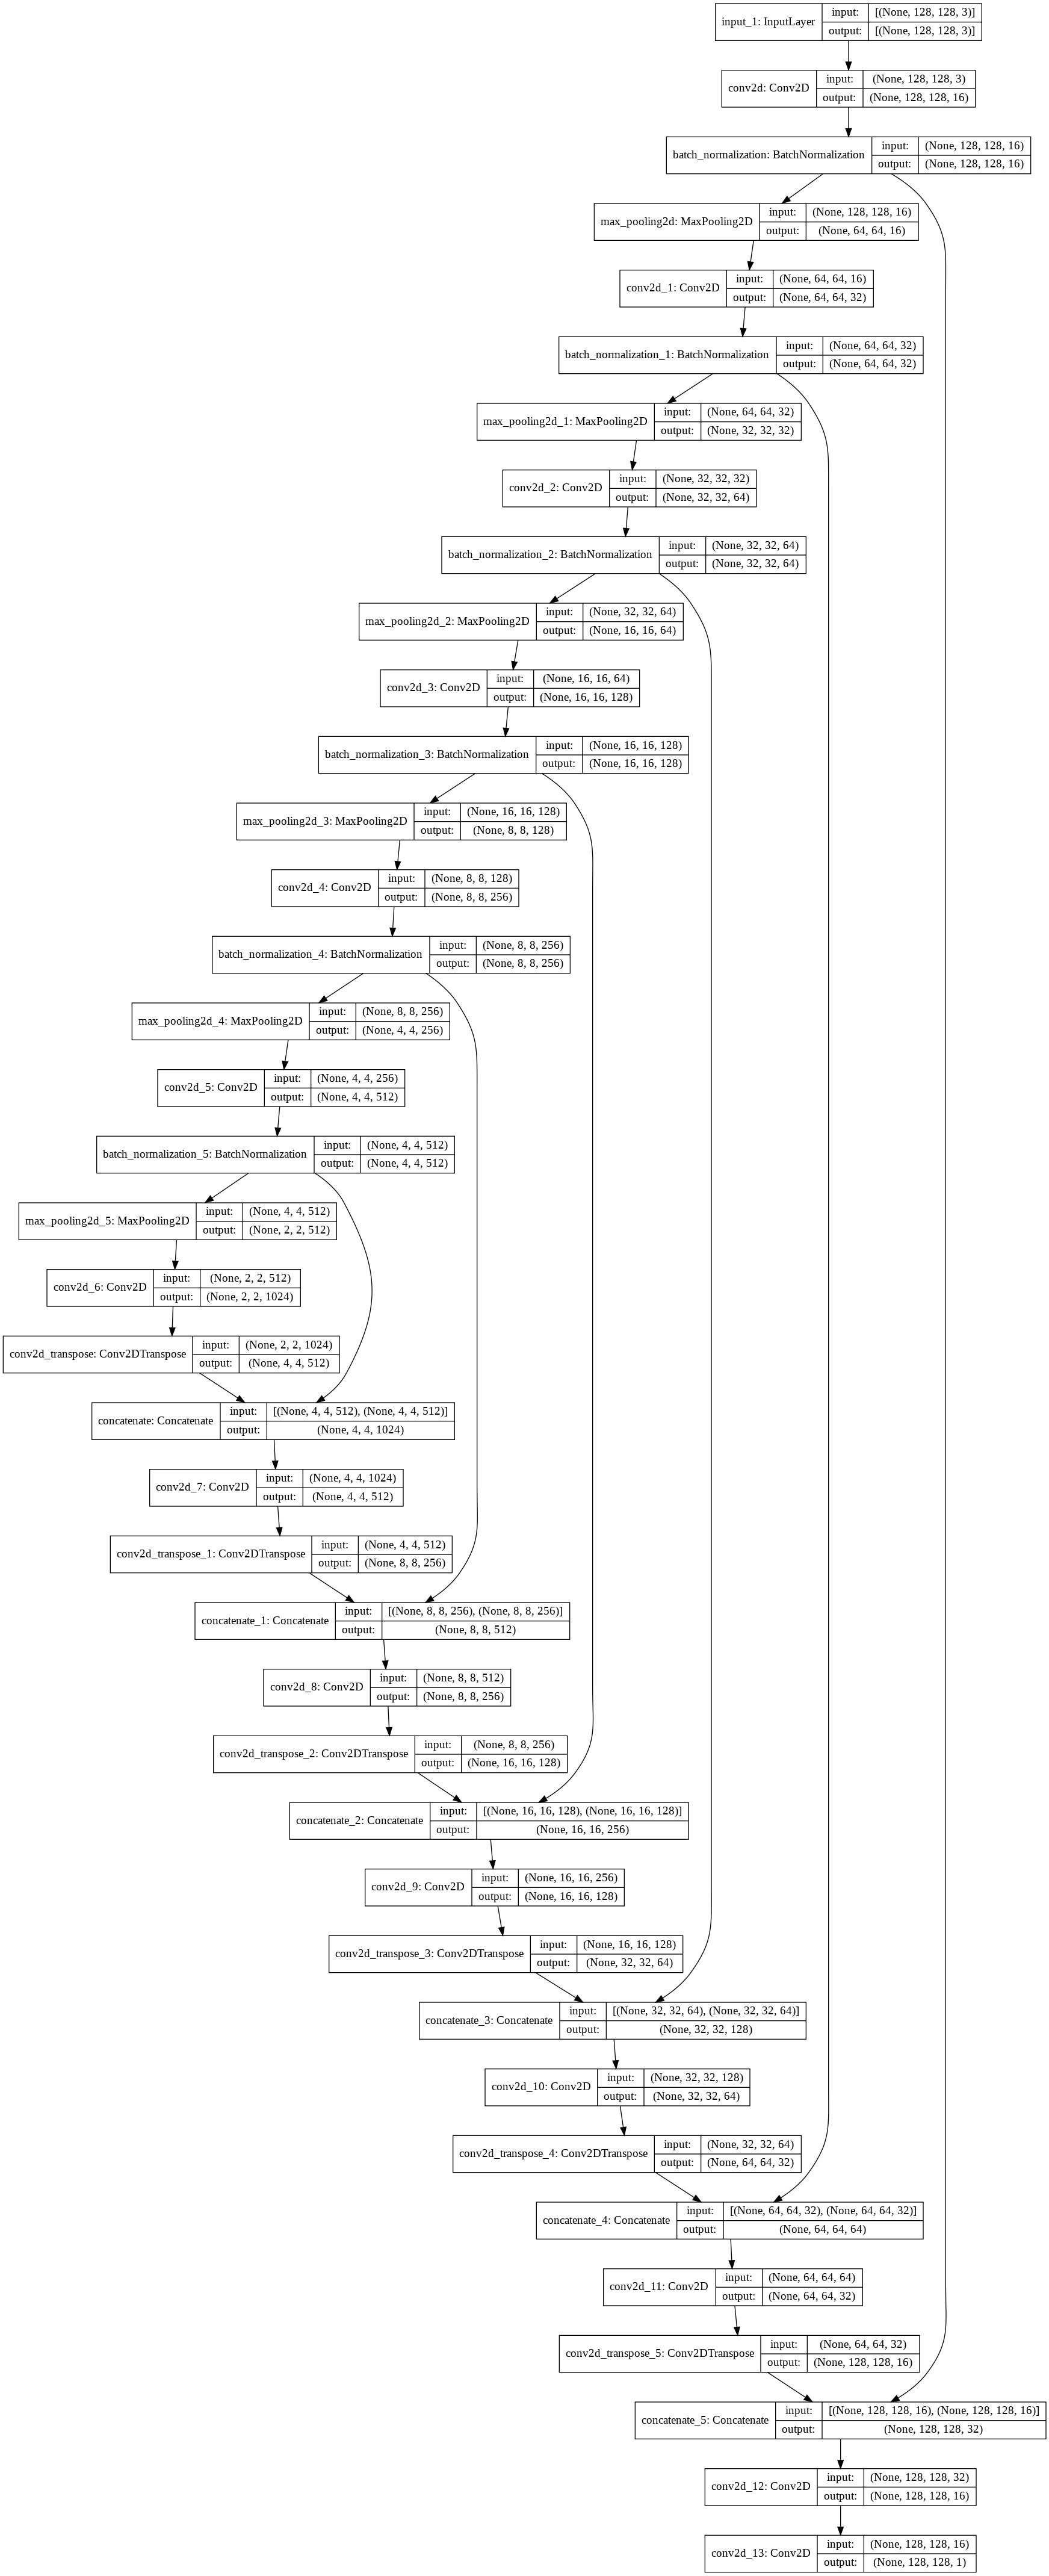

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
model.fit(x_train, y_train, batch_size=64,epochs=150)

Epoch 1/150
58/58 [==============================] - 46s 155ms/step - loss: 0.5016 - mse: 0.5016
Epoch 2/150
58/58 [==============================] - 7s 118ms/step - loss: 0.2807 - mse: 0.2807
Epoch 3/150
58/58 [==============================] - 7s 120ms/step - loss: 0.2353 - mse: 0.2353
Epoch 4/150
58/58 [==============================] - 7s 120ms/step - loss: 0.2081 - mse: 0.2081
Epoch 5/150
58/58 [==============================] - 7s 120ms/step - loss: 0.1877 - mse: 0.1877
Epoch 6/150
58/58 [==============================] - 7s 121ms/step - loss: 0.1710 - mse: 0.1710
Epoch 7/150
58/58 [==============================] - 7s 122ms/step - loss: 0.1560 - mse: 0.1560
Epoch 8/150
58/58 [==============================] - 7s 123ms/step - loss: 0.1430 - mse: 0.1430
Epoch 9/150
58/58 [==============================] - 7s 123ms/step - loss: 0.1336 - mse: 0.1336
Epoch 10/150
58/58 [==============================] - 7s 124ms/step - loss: 0.1252 - mse: 0.1252
Epoch 11/150
58/58 [==================

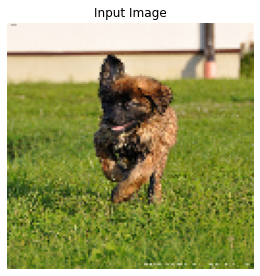

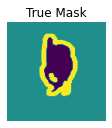

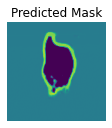

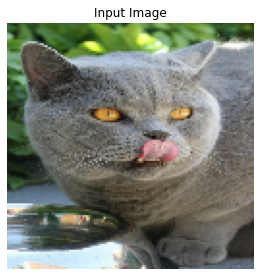

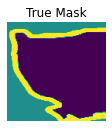

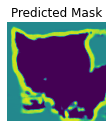

In [15]:
def create_mask(pred_mask):
   pred_mask = tf.argmax(pred_mask, axis=-1)
   pred_mask = pred_mask[..., tf.newaxis]
   return pred_mask[0]

def show_predictions(dataset=None, num=1):
   if dataset:
      for image, mask in dataset.take(num):
         pred_mask = model.predict(image)
         display([image[0], mask[0], pred_mask[0]])
   else:
      display([sample_image, sample_mask,
      create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions(test_dataset, 2)